In [23]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the ticker symbol
ticker = "AAPL"

In [2]:
data = yf.download(ticker,start='2018-01-01',end='2023-12-31')

[*********************100%***********************]  1 of 1 completed


In [22]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
0,0.040270,0.035021,0.036460,0.034734,0.194243
1,0.040227,0.038252,0.040378,0.038161,0.233620
2,0.041381,0.036701,0.040552,0.038176,0.163221
3,0.044220,0.039429,0.041960,0.039477,0.175400
4,0.043283,0.039774,0.043236,0.040793,0.144667


In [253]:
data.to_csv('data.csv', index=False)

In [4]:
data = data.dropna()

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [6]:
data = pd.DataFrame(data_normalized, columns=data.columns)
train_size = int(len(data) * 0.75)
train_data = data[:train_size]
test_data = data[train_size:]

In [7]:
test_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1131,0.618495,0.620796,0.604865,0.621048,0.186145
1132,0.631856,0.624830,0.616366,0.613709,0.116789
1133,0.647756,0.640304,0.624094,0.624201,0.122510
1134,0.655978,0.655418,0.649347,0.645913,0.124275
1135,0.676714,0.670049,0.662734,0.657679,0.104868


In [9]:
from stable_baselines3 import PPO

import gym

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance =500 # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        # Ensure we don't exceed the data length
        if self.current_step >= len(self.data):
            done = True
            self.current_step = 0  # Restart the episode
        else:
            done = False

        return self._next_observation(), self._get_reward(), done, {}

    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step].values[0]

        if action == 0:  # Buy
            # Ensure you only buy if you have enough balance
            print("buying", current_price)
            if self.account_balance > current_price:
                self.shares_held += self.account_balance / current_price
                self.account_balance = 0  # Spend all the balance
        elif action == 1:  # Sell
            if self.shares_held > 0:
                self.account_balance += self.shares_held * current_price
                self.shares_held = 0  # Sell all shares

        # Calculate the net worth after the action

        self.net_worth = self.account_balance + self.shares_held * current_price

        # Track the maximum net worth to encourage the model to maximize it
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):
        # Reward can be the difference between the current net worth and previous net worth
        return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])
# Create the trading environment
env = TradingEnvironment(train_data)

In [272]:
model = PPO("MlpPolicy", env, verbose=1,device="cpu")

# Train the model
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
buying 0.040270515151446445
buying 0.040227246976960646
buying 0.04138050394964099
buying 0.05036146691126547
buying 0.04710347388742292
buying 0.04716116478673732
buying 0.0430959900593999
buying 0.03861271994100193
buying 0.03330782201871349
buying 0.03381224337864275
buying 0.023317759205993688
buying 0.017537028242196412
buying 0.026964955420105574
buying 0.027459933050973634
buying 0.03420497627952654
buying 0.041529055677818866
buying 0.041630365385123796
buying 0.0470003876370273
buying 0.0478833061775476
buying 0.045292358333135996
buying 0.05497578045817092
buying 0.05244275726874359
buying 0.050228132677193615
buying 0.04559628745505084
buying 0.03634715998899571
buying 0.030687701466706963
buying 0.04202118148951495
buying 0.03560905308593598
buying 0.03320625518017173
buying 0.04206451979070169
buying 0.03566686086308532
buying 0.04271587996468701
buying 0.04643584431881742
buying 

J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


buying 0.1280906502617561
buying 0.12422589764573211
buying 0.12812031385625772
buying 0.1417135566904601
buying 0.14039573572621844
buying 0.13898892397847196
buying 0.1403364552883492
buying 0.18136375442087488
buying 0.18100732377551593
buying 0.186651027165658
buying 0.1807400007914967
buying 0.18446765570716456
buying 0.18427471377728566
buying 0.18068050997352458
buying 0.18638375093277276
buying 0.19400259623072252
buying 0.19511667575313912
buying 0.21414190946731732
buying 0.23720681516525438
buying 0.2626926815845016
buying 0.2563361636547755
buying 0.2543458743795628
buying 0.2621135285369272
buying 0.2693613100845866
buying 0.2749454992811896
buying 0.2687822505392802
buying 0.2579890499961535
buying 0.19914012509341167
buying 0.22266192962360126
buying 0.18819816244200432
buying 0.20198362256350916
buying 0.16149057201438316
buying 0.15252851988644806
buying 0.16838332545070256
buying 0.1607611374466742
buying 0.19873825234583747
buying 0.20421669047740876
buying 0.2029810

C:\Users\PKM\AppData\Local\Temp\ipykernel_8712\403372843.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.shares_held += self.account_balance / current_price
C:\Users\PKM\AppData\Local\Temp\ipykernel_8712\403372843.py:53: RuntimeWarning: invalid value encountered in scalar multiply
  self.net_worth = self.account_balance + self.shares_held * current_price
C:\Users\PKM\AppData\Local\Temp\ipykernel_8712\403372843.py:61: RuntimeWarning: invalid value encountered in scalar subtract
  return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])


buying

KeyboardInterrupt: 

In [26]:
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data)
    obs = env.reset()

    # Initialize a list to store net worth at each time step
    net_worth_history = [env.net_worth]

    for i in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, done, _ = env.step(action)

        # Append the current net worth to the history
        net_worth_history.append(env.net_worth)

        if done:
            print("Simulation terminated early.")
            break

    return net_worth_history


In [27]:
net_worth = simulate_trading_strategy(model, test_data)
from stable_baselines3 import PPO
from stable_baselines3.common.envs import DummyVecEnv


buying 0.7274641646705879
buying 0.7297437500160707
buying 0.7210941355142426
buying 0.8384173244746165
buying 0.8565406824870949
buying 0.996707130553246
Simulation terminated early.


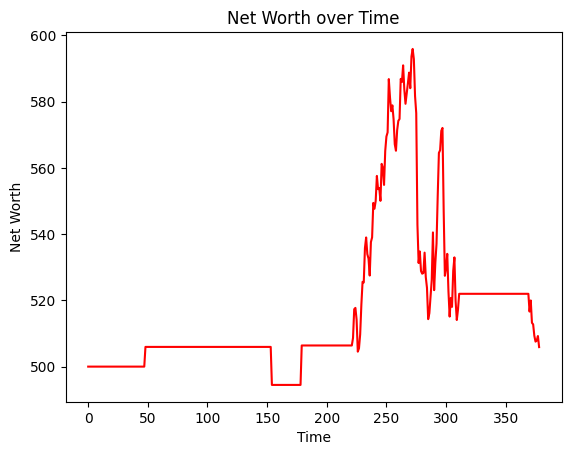

In [28]:
import matplotlib.pyplot as plt


# Plot the net worth over time
plt.plot(net_worth,color='red')
plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time")
plt.show()

In [296]:
print(net_worth)

[500, np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(508.74886704131876), np.float64(518.6557240659378), np.float64(513.2520140207129), np.float64(508.3628261601863), np.float64(508.3628261601863), np.float64(508.3628261601863), np.float64(508.3628261601863), np.float64(529.7004054223551), np.float64(525.5651378049319), np.float64(519.3624282468234), np.float64(519.3624282468234), np.float64(519.3624282468234), np.float64(519.3624282468234), np.float64(517.4592648116666), np.float64(517.6574382800248), np.float64(534.7867665600191), np.float64(534.7867665600191), np.float64(549.1808629567539), np.float64(553.5268779947043), np.float64(552.8888811150186), np.float64(558.9496051411894), np.float64(557.3547361073964), np.float64(546.8682474333147), np.float64(531.118530832669), np.

In [13]:
def evaluate_model(model, env, num_episodes=100):
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    avg_total_reward = np.mean(total_rewards)
    print(f"Average total reward over {num_episodes} episodes: {avg_total_reward}")



In [24]:
test_env = TradingEnvironment(test_data)
evaluate_model(model, test_env)


buying 0.699071171824213
buying 0.6590983903350444
buying 0.9357845109281946
buying 0.8627892521945568
buying 0.8819723649365552
buying 0.6559777520698481
buying 0.8303210564073482
buying 0.7270404123824121
buying 0.710694906533962
buying 0.6622026657029699
buying 0.9171138841287143
buying 0.8869051706989131
buying 0.9487777733883656
buying 0.7223695064786554
buying 0.7759964244731906
buying 0.8733868929920283
buying 0.5915454312336386
buying 0.5500676839557819
buying 0.5798418455852085
buying 0.6669207902531363
buying 0.7592948619801303
buying 0.9292164439637389
buying 0.986687988300996
buying 0.8725939937414255
buying 0.6685592305324183
buying 0.7026376289133329
buying 0.7184219341365334
buying 0.8339232313636535
buying 0.6780955270617777
buying 0.7065183471323204
buying 0.9928654962831678
buying 0.7432150895833562
buying 0.6997271837513624
buying 0.7120368511146989
buying 0.7978600602949388
buying 0.699071171824213
buying 0.7068218555011242
buying 0.735305545549514
buying 0.78656377

In [10]:
from stable_baselines3 import DDPG, A2C, DQN

model = DQN("MlpPolicy", env, device="cuda",verbose=0)


model.learn(total_timesteps=100000,log_interval=4)




J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


buying 0.04422033248939741
buying 0.04319685664068315
buying 0.04723323276384997
buying 0.045935842014824285
buying 0.047103498364060886
buying 0.03330772929503262
buying 0.02331775975105954
buying 0.015605365253761633
buying 0.027459863566162535
buying 0.04152896314631399
buying 0.0406894997651924
buying 0.03956055335578479
buying 0.04163029623155462
buying 0.045972681909250884
buying 0.04700034198455297
buying 0.054975711616558426
buying 0.05053213310702667
buying 0.0455962885208899
buying 0.03984998963293579
buying 0.036347207589766256
buying 0.03068767880848186
buying 0.04202115909621637
buying 0.03568135454868673
buying 0.04034211545613561
buying 0.03808408238391517
buying 0.04993867419858619
buying 0.03112195010204602
buying 0.029645525881311474
buying 0.031150865679080098
buying 0.059954964631597524
buying 0.06124319215815158
buying 0.06313923119160927
buying 0.06597227984948936
buying 0.06457736623273039
buying 0.06389440227621926
buying 0.06595774024648601
buying 0.06438844489

In [317]:
model.save("DQN")